# Julia 深度學習：卷積神經網路模型簡介

## 作業 033：訓練 CNN 學習門牌號碼資料集

訓練一個 CNN 模型來學習門牌號碼資料集。

In [48]:
using Flux
using Flux.Data: DataLoader
using Flux: @epochs, onecold, onehotbatch, throttle, logitcrossentropy
using MLDatasets
using Statistics

using Plots
using Images # for rgb, colorview

## 讀取資料

In [49]:
train_X, train_y = SVHN2.traindata(Float32, 1:20000, dir = "D:\\julia\\data\\SVHN2")
test_X,  test_y  = SVHN2.testdata(Float32, 1:2000, dir = "D:\\julia\\data\\SVHN2")

(Float32[0.14901961 0.15294118 … 0.19607843 0.1882353; 0.15294118 0.15294118 … 0.2 0.1882353; … ; 0.16470589 0.16862746 … 0.1764706 0.17254902; 0.15294118 0.15294118 … 0.16470589 0.16470589]

Float32[0.40392157 0.40784314 … 0.45882353 0.4509804; 0.40784314 0.40784314 … 0.4627451 0.4509804; … ; 0.40392157 0.39607844 … 0.45490196 0.4509804; 0.38039216 0.38039216 … 0.44313726 0.44313726]

Float32[0.23529412 0.23921569 … 0.29803923 0.2901961; 0.23921569 0.23921569 … 0.3019608 0.2901961; … ; 0.24313726 0.24705882 … 0.28235295 0.2784314; 0.22352941 0.22352941 … 0.27058825 0.2784314]

Float32[0.5058824 0.5254902 … 0.5411765 0.5137255; 0.49803922 0.52156866 … 0.50980395 0.47843137; … ; 0.48235294 0.49411765 … 0.39607844 0.43529412; 0.48235294 0.49019608 … 0.4392157 0.48235294]

Float32[0.5568628 0.5882353 … 0.59607846 0.5686275; 0.56078434 0.58431375 … 0.5647059 0.53333336; … ; 0.5254902 0.5372549 … 0.41960785 0.4627451; 0.5294118 0.5372549 … 0.4627451 0.50980395]

Float32[0.6 0.627451 … 0.647

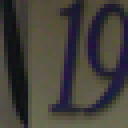

In [50]:
img1_RGB = Float64.(train_X[:,:,:,1])
colorview(RGB,permutedims(img1_RGB,[3,2,1]))

In [51]:
categories_y = unique(train_y)
categories_y = UnitRange(min(categories_y...),max(categories_y...))

1:10

In [52]:
train_y = onehotbatch(train_y, categories_y)
test_y = onehotbatch(test_y, categories_y)

10×2000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  1  0  0  1  0  1  1  0  0  0  0  …  0  0  0  0  0  0  1  0  0  0  1  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  1  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  1     0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  1  0  …  0  0  0  1  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  1  0  0  0  0  0  1  0  1  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

## CNN 模型

In [115]:
ch = [3,16,32,32];
padding = (1,1);
sigma = relu;

In [116]:
inputsize = size(img1_RGB)

(32, 32, 3)

In [125]:
convlayers = Chain(
                    Conv((3,3), ch[1]=>ch[2], pad = padding,sigma),
                    MaxPool((2,2)),
                    Conv((3,3), ch[2]=>ch[3], pad = padding,sigma),
                    MaxPool((2,2)),
                    Conv((3,3), ch[3]=>ch[4], pad = padding,sigma),
                    );
convlyoutsize = Flux.outdims(convlayers,inputsize[1:2])

(8, 8)

In [126]:
dense_in = prod((convlyoutsize...,ch[4]))
dense_out = length(categories_y)

10

In [127]:
model = Chain(
    convlayers,
    flatten,
    Dense(dense_in,dense_out),
    softmax
    );

DataLoader必須要在 `XXX |> gpu`之後做，否則會出錯

In [128]:
using CuArrays
model = model |> gpu
train_X = train_X |> gpu
train_y = train_y |> gpu
test_X = test_X |> gpu
test_y = test_y |> gpu
# there is a warning, feel free to ignore it (by ZK 2020-05-29)

10×2000 Flux.OneHotMatrix{CuArray{Flux.OneHotVector,1,Nothing}}:
 0  0  1  0  0  1  0  1  1  0  0  0  0  …  0  0  0  0  0  0  1  0  0  0  1  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  1  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  1     0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  1  0  …  0  0  0  1  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  1  0  0  0  0  0  1  0  1  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

In [129]:
batchsize = 1024
train = DataLoader(train_X, train_y, batchsize=batchsize, shuffle=true)
test = DataLoader(test_X, test_y, batchsize=batchsize);

In [130]:
# loss(x, y) = Flux.logitcrossentropy(model(x), y)
loss(x, y) = Flux.logitcrossentropy(model(x), y)
function test_loss()
    l = 0f0
    for (x, y) in test
        l += loss(x, y)
    end
    l/length(test)
end
evalcb() = @show(test_loss())
# ZK's setting
learining_rate = 0.002;
decay = 0.1;
decay_step = 1;
clip = 1e-4;
optimizer = Flux.Optimiser(ExpDecay(learining_rate, decay, decay_step, clip), ADAM(learining_rate));

In [131]:
epochs = 20
# @epochs epochs Flux.train!(loss, params(model), train, ADAM(0.005), cb=throttle(evalcb, 10))
@epochs epochs Flux.train!(loss, params(model), train, optimizer, cb=throttle(evalcb, 10))

┌ Info: Epoch 1
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2969408f0


┌ Info: Epoch 2
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.2505584f0


┌ Info: Epoch 3
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.245726f0


┌ Info: Epoch 4
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.196334f0


┌ Info: Epoch 5
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.1564589f0


┌ Info: Epoch 6
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.145183f0


┌ Info: Epoch 7
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.138475f0


┌ Info: Epoch 8
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.1381235f0


┌ Info: Epoch 9
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.1359825f0


┌ Info: Epoch 10
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.133601f0


┌ Info: Epoch 11
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.1325274f0


┌ Info: Epoch 12
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.1020246f0


┌ Info: Epoch 13
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.0873754f0


┌ Info: Epoch 14
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.0744977f0


┌ Info: Epoch 15
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.064385f0


┌ Info: Epoch 16
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.0640106f0


┌ Info: Epoch 17
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.055801f0


┌ Info: Epoch 18
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.0597582f0


┌ Info: Epoch 19
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.050664f0


┌ Info: Epoch 20
└ @ Main C:\Users\HSI\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


test_loss() = 2.0499578f0


In [132]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
accuracy(test_X, test_y)

0.4125